# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

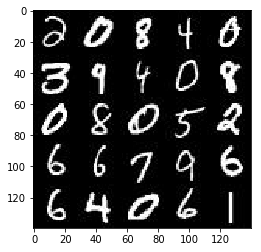

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

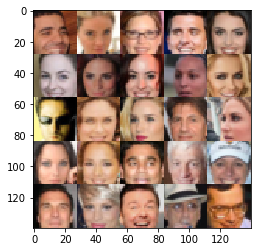

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1


/home/seanfitz/anaconda2/envs/dlnd/lib/python3.6/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [78]:
# NOTE: I'm adding alpha to the method signature here to use leaky relu
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse) as scope:
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x56
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x112
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        
        x4 = tf.layers.conv2d(relu3, 512, 5, strides=2, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        # 2x2x512

        # Flatten it
        flat = tf.reshape(relu4, (-1, 2*2*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [79]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 2x2x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 2, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 4x4x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 4, strides=1)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 7x7x128
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        # 4x4x256 now
        
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [80]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [81]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [82]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np
import matplotlib.pyplot as pyplt

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [83]:
import numpy as np
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    print_every = 10
    show_every = 100
    # TODO: Build Model
    input_real, input_z, lr_placeholder = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], alpha=0.2)
        
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    # Train
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(50, z_dim))

    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                transformed_batch = batch_images * 2.0 # scale from [-0.5, 0.5] to [-1.0, 1.0]

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: transformed_batch, input_z: batch_z, lr_placeholder: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, lr_placeholder: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: transformed_batch, lr_placeholder: learning_rate})
                    train_loss_g = g_loss.eval({input_z: batch_z, lr_placeholder: learning_rate})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4906... Generator Loss: 1.7925
Epoch 1/2... Discriminator Loss: 0.8582... Generator Loss: 1.7360
Epoch 1/2... Discriminator Loss: 0.3383... Generator Loss: 1.5234
Epoch 1/2... Discriminator Loss: 0.6384... Generator Loss: 2.4131
Epoch 1/2... Discriminator Loss: 0.3663... Generator Loss: 1.4371
Epoch 1/2... Discriminator Loss: 0.9282... Generator Loss: 3.4488
Epoch 1/2... Discriminator Loss: 0.9923... Generator Loss: 0.7809
Epoch 1/2... Discriminator Loss: 0.2688... Generator Loss: 3.1583
Epoch 1/2... Discriminator Loss: 0.7162... Generator Loss: 2.0583
Epoch 1/2... Discriminator Loss: 2.4639... Generator Loss: 0.1284


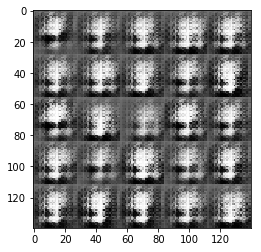

Epoch 1/2... Discriminator Loss: 0.9973... Generator Loss: 0.6604
Epoch 1/2... Discriminator Loss: 2.8531... Generator Loss: 8.2361
Epoch 1/2... Discriminator Loss: 1.0796... Generator Loss: 0.5138
Epoch 1/2... Discriminator Loss: 0.2158... Generator Loss: 1.8597
Epoch 1/2... Discriminator Loss: 0.1457... Generator Loss: 3.0503
Epoch 1/2... Discriminator Loss: 0.6932... Generator Loss: 0.9473
Epoch 1/2... Discriminator Loss: 1.4585... Generator Loss: 0.7802
Epoch 1/2... Discriminator Loss: 1.0887... Generator Loss: 3.4783
Epoch 1/2... Discriminator Loss: 0.7002... Generator Loss: 1.5464
Epoch 1/2... Discriminator Loss: 0.5465... Generator Loss: 1.5081


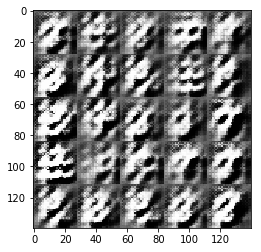

Epoch 1/2... Discriminator Loss: 1.4130... Generator Loss: 3.1516
Epoch 1/2... Discriminator Loss: 0.6471... Generator Loss: 1.2498
Epoch 1/2... Discriminator Loss: 0.4289... Generator Loss: 1.9310
Epoch 1/2... Discriminator Loss: 0.4275... Generator Loss: 2.0518
Epoch 1/2... Discriminator Loss: 0.8428... Generator Loss: 1.0014
Epoch 1/2... Discriminator Loss: 0.9494... Generator Loss: 1.0719
Epoch 1/2... Discriminator Loss: 0.5004... Generator Loss: 1.1786
Epoch 1/2... Discriminator Loss: 0.6339... Generator Loss: 0.9630
Epoch 1/2... Discriminator Loss: 0.5778... Generator Loss: 1.6056
Epoch 1/2... Discriminator Loss: 0.9643... Generator Loss: 0.7529


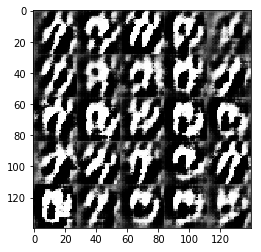

Epoch 1/2... Discriminator Loss: 0.4706... Generator Loss: 2.5537
Epoch 1/2... Discriminator Loss: 0.4672... Generator Loss: 1.5725
Epoch 1/2... Discriminator Loss: 0.2105... Generator Loss: 2.3200
Epoch 1/2... Discriminator Loss: 0.9983... Generator Loss: 0.5741
Epoch 1/2... Discriminator Loss: 1.7407... Generator Loss: 7.0232
Epoch 1/2... Discriminator Loss: 0.5887... Generator Loss: 1.9812
Epoch 1/2... Discriminator Loss: 0.2601... Generator Loss: 2.6218
Epoch 1/2... Discriminator Loss: 0.5316... Generator Loss: 3.2838
Epoch 1/2... Discriminator Loss: 0.6666... Generator Loss: 1.0120
Epoch 1/2... Discriminator Loss: 0.8093... Generator Loss: 1.0711


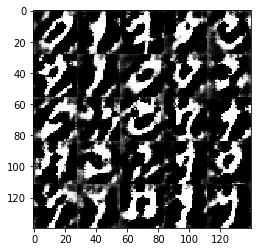

Epoch 1/2... Discriminator Loss: 1.8002... Generator Loss: 0.2469
Epoch 1/2... Discriminator Loss: 0.9477... Generator Loss: 4.2448
Epoch 1/2... Discriminator Loss: 0.5844... Generator Loss: 3.7867
Epoch 1/2... Discriminator Loss: 2.2680... Generator Loss: 0.1557
Epoch 1/2... Discriminator Loss: 1.3626... Generator Loss: 0.6219
Epoch 1/2... Discriminator Loss: 0.9887... Generator Loss: 2.1266
Epoch 1/2... Discriminator Loss: 0.4895... Generator Loss: 1.5101
Epoch 1/2... Discriminator Loss: 1.4334... Generator Loss: 0.3646
Epoch 1/2... Discriminator Loss: 0.4666... Generator Loss: 1.4565
Epoch 1/2... Discriminator Loss: 1.5437... Generator Loss: 2.6516


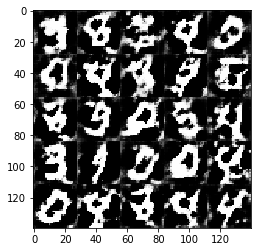

Epoch 1/2... Discriminator Loss: 0.7425... Generator Loss: 1.0515
Epoch 1/2... Discriminator Loss: 0.5048... Generator Loss: 1.6020
Epoch 1/2... Discriminator Loss: 0.5459... Generator Loss: 2.7802
Epoch 1/2... Discriminator Loss: 0.7434... Generator Loss: 1.3105
Epoch 1/2... Discriminator Loss: 2.0821... Generator Loss: 0.2005
Epoch 1/2... Discriminator Loss: 0.5658... Generator Loss: 1.3329
Epoch 1/2... Discriminator Loss: 0.6858... Generator Loss: 1.3497
Epoch 1/2... Discriminator Loss: 0.5225... Generator Loss: 2.4474
Epoch 1/2... Discriminator Loss: 1.9715... Generator Loss: 4.0018
Epoch 1/2... Discriminator Loss: 0.7020... Generator Loss: 1.0355


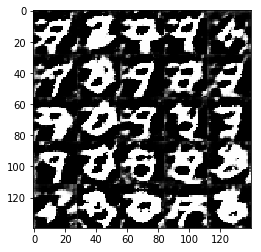

Epoch 1/2... Discriminator Loss: 1.0582... Generator Loss: 0.6583
Epoch 1/2... Discriminator Loss: 0.9075... Generator Loss: 0.9972
Epoch 1/2... Discriminator Loss: 0.4035... Generator Loss: 1.8417
Epoch 1/2... Discriminator Loss: 1.0347... Generator Loss: 0.7981
Epoch 1/2... Discriminator Loss: 1.2584... Generator Loss: 1.0226
Epoch 1/2... Discriminator Loss: 1.1570... Generator Loss: 0.5364
Epoch 1/2... Discriminator Loss: 1.4203... Generator Loss: 4.7401
Epoch 1/2... Discriminator Loss: 1.0012... Generator Loss: 0.6016
Epoch 1/2... Discriminator Loss: 1.8701... Generator Loss: 0.2302
Epoch 1/2... Discriminator Loss: 1.4646... Generator Loss: 0.4531


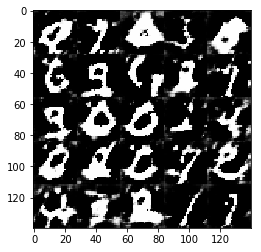

Epoch 1/2... Discriminator Loss: 0.4504... Generator Loss: 1.6911
Epoch 1/2... Discriminator Loss: 0.7336... Generator Loss: 0.9889
Epoch 1/2... Discriminator Loss: 0.8707... Generator Loss: 3.4711
Epoch 1/2... Discriminator Loss: 0.6109... Generator Loss: 1.0479
Epoch 1/2... Discriminator Loss: 0.6836... Generator Loss: 1.5742
Epoch 1/2... Discriminator Loss: 0.4216... Generator Loss: 1.7789
Epoch 1/2... Discriminator Loss: 0.4055... Generator Loss: 2.5821
Epoch 1/2... Discriminator Loss: 1.1847... Generator Loss: 4.3426
Epoch 1/2... Discriminator Loss: 0.4437... Generator Loss: 1.4870
Epoch 1/2... Discriminator Loss: 0.5605... Generator Loss: 1.1672


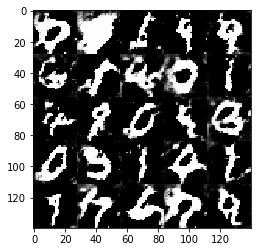

Epoch 1/2... Discriminator Loss: 0.6003... Generator Loss: 1.7549
Epoch 1/2... Discriminator Loss: 1.0439... Generator Loss: 0.6194
Epoch 1/2... Discriminator Loss: 0.5518... Generator Loss: 1.4385
Epoch 1/2... Discriminator Loss: 0.5128... Generator Loss: 1.2907
Epoch 1/2... Discriminator Loss: 0.7788... Generator Loss: 0.8128
Epoch 1/2... Discriminator Loss: 0.7222... Generator Loss: 1.0951
Epoch 1/2... Discriminator Loss: 1.2573... Generator Loss: 4.5849
Epoch 1/2... Discriminator Loss: 1.1157... Generator Loss: 0.5298
Epoch 1/2... Discriminator Loss: 0.6837... Generator Loss: 1.5859
Epoch 1/2... Discriminator Loss: 0.5115... Generator Loss: 2.1205


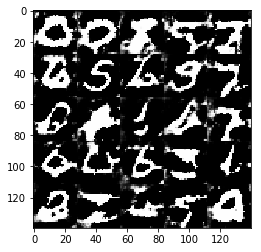

Epoch 1/2... Discriminator Loss: 0.7101... Generator Loss: 1.0559
Epoch 1/2... Discriminator Loss: 0.5525... Generator Loss: 1.4245
Epoch 1/2... Discriminator Loss: 0.5026... Generator Loss: 1.6083
Epoch 2/2... Discriminator Loss: 0.5955... Generator Loss: 1.6644
Epoch 2/2... Discriminator Loss: 0.6241... Generator Loss: 3.0690
Epoch 2/2... Discriminator Loss: 2.0534... Generator Loss: 0.2553
Epoch 2/2... Discriminator Loss: 0.5769... Generator Loss: 1.3758
Epoch 2/2... Discriminator Loss: 1.3409... Generator Loss: 0.7843
Epoch 2/2... Discriminator Loss: 0.2422... Generator Loss: 2.9815
Epoch 2/2... Discriminator Loss: 1.9936... Generator Loss: 0.2240


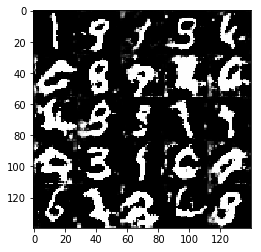

Epoch 2/2... Discriminator Loss: 0.4137... Generator Loss: 3.2865
Epoch 2/2... Discriminator Loss: 0.6254... Generator Loss: 1.6958
Epoch 2/2... Discriminator Loss: 1.3869... Generator Loss: 0.5912
Epoch 2/2... Discriminator Loss: 0.9713... Generator Loss: 0.7122
Epoch 2/2... Discriminator Loss: 1.0314... Generator Loss: 0.8207
Epoch 2/2... Discriminator Loss: 0.9007... Generator Loss: 2.9221
Epoch 2/2... Discriminator Loss: 0.5776... Generator Loss: 1.1055
Epoch 2/2... Discriminator Loss: 1.8379... Generator Loss: 0.2982
Epoch 2/2... Discriminator Loss: 0.5389... Generator Loss: 1.1452
Epoch 2/2... Discriminator Loss: 0.6662... Generator Loss: 1.2788


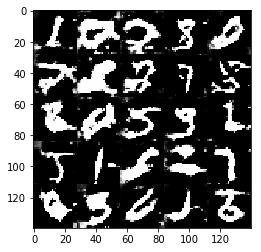

Epoch 2/2... Discriminator Loss: 0.3717... Generator Loss: 1.6991
Epoch 2/2... Discriminator Loss: 0.7612... Generator Loss: 1.0105
Epoch 2/2... Discriminator Loss: 0.7284... Generator Loss: 0.9675
Epoch 2/2... Discriminator Loss: 1.2267... Generator Loss: 0.4472
Epoch 2/2... Discriminator Loss: 0.5171... Generator Loss: 1.9413
Epoch 2/2... Discriminator Loss: 1.7938... Generator Loss: 0.2483
Epoch 2/2... Discriminator Loss: 1.3027... Generator Loss: 0.3852
Epoch 2/2... Discriminator Loss: 1.4292... Generator Loss: 0.3251
Epoch 2/2... Discriminator Loss: 1.7367... Generator Loss: 0.2649
Epoch 2/2... Discriminator Loss: 2.4720... Generator Loss: 6.1960


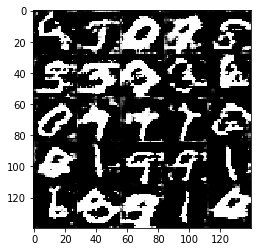

Epoch 2/2... Discriminator Loss: 0.8675... Generator Loss: 1.1396
Epoch 2/2... Discriminator Loss: 0.3717... Generator Loss: 1.5906
Epoch 2/2... Discriminator Loss: 1.7379... Generator Loss: 0.3038
Epoch 2/2... Discriminator Loss: 0.7739... Generator Loss: 2.0780
Epoch 2/2... Discriminator Loss: 1.6259... Generator Loss: 0.2880
Epoch 2/2... Discriminator Loss: 1.0675... Generator Loss: 1.2261
Epoch 2/2... Discriminator Loss: 0.8204... Generator Loss: 0.7699
Epoch 2/2... Discriminator Loss: 1.9570... Generator Loss: 0.2119
Epoch 2/2... Discriminator Loss: 1.7198... Generator Loss: 0.2861
Epoch 2/2... Discriminator Loss: 1.2304... Generator Loss: 0.4872


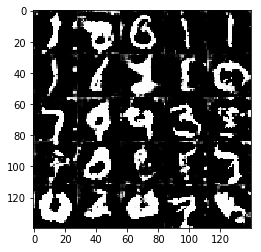

Epoch 2/2... Discriminator Loss: 0.8029... Generator Loss: 0.7679
Epoch 2/2... Discriminator Loss: 2.2657... Generator Loss: 0.1511
Epoch 2/2... Discriminator Loss: 0.6842... Generator Loss: 3.1061
Epoch 2/2... Discriminator Loss: 0.9936... Generator Loss: 0.6399
Epoch 2/2... Discriminator Loss: 1.8319... Generator Loss: 0.2195
Epoch 2/2... Discriminator Loss: 3.3736... Generator Loss: 0.2566
Epoch 2/2... Discriminator Loss: 0.4450... Generator Loss: 2.9468
Epoch 2/2... Discriminator Loss: 0.9842... Generator Loss: 0.6627
Epoch 2/2... Discriminator Loss: 2.1153... Generator Loss: 0.3408
Epoch 2/2... Discriminator Loss: 1.7390... Generator Loss: 0.6789


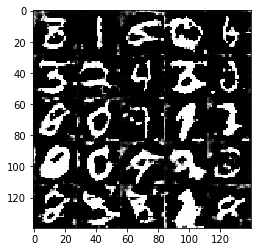

Epoch 2/2... Discriminator Loss: 0.7287... Generator Loss: 1.2767
Epoch 2/2... Discriminator Loss: 1.6363... Generator Loss: 0.2835
Epoch 2/2... Discriminator Loss: 0.4672... Generator Loss: 1.4663
Epoch 2/2... Discriminator Loss: 0.6545... Generator Loss: 1.0320
Epoch 2/2... Discriminator Loss: 1.0472... Generator Loss: 3.4121
Epoch 2/2... Discriminator Loss: 0.6003... Generator Loss: 1.2626
Epoch 2/2... Discriminator Loss: 0.8398... Generator Loss: 1.0829
Epoch 2/2... Discriminator Loss: 0.8195... Generator Loss: 1.7340
Epoch 2/2... Discriminator Loss: 0.2715... Generator Loss: 3.2012
Epoch 2/2... Discriminator Loss: 0.9940... Generator Loss: 0.5982


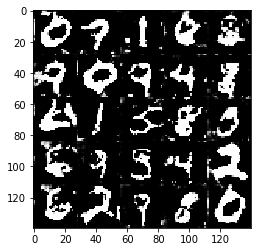

Epoch 2/2... Discriminator Loss: 0.4059... Generator Loss: 1.4098
Epoch 2/2... Discriminator Loss: 0.9457... Generator Loss: 4.3032
Epoch 2/2... Discriminator Loss: 1.9318... Generator Loss: 0.3095
Epoch 2/2... Discriminator Loss: 0.8830... Generator Loss: 0.6623
Epoch 2/2... Discriminator Loss: 1.6764... Generator Loss: 0.2924
Epoch 2/2... Discriminator Loss: 0.5653... Generator Loss: 2.0473
Epoch 2/2... Discriminator Loss: 1.2468... Generator Loss: 0.5792
Epoch 2/2... Discriminator Loss: 0.6907... Generator Loss: 0.9345
Epoch 2/2... Discriminator Loss: 2.1290... Generator Loss: 0.1738
Epoch 2/2... Discriminator Loss: 1.1136... Generator Loss: 0.7148


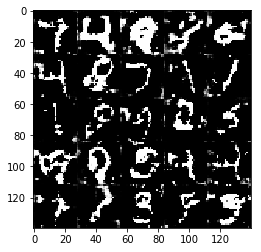

Epoch 2/2... Discriminator Loss: 1.2876... Generator Loss: 1.6298
Epoch 2/2... Discriminator Loss: 0.7595... Generator Loss: 0.8719
Epoch 2/2... Discriminator Loss: 0.8754... Generator Loss: 0.8537
Epoch 2/2... Discriminator Loss: 0.6388... Generator Loss: 1.1416
Epoch 2/2... Discriminator Loss: 0.4669... Generator Loss: 1.9250
Epoch 2/2... Discriminator Loss: 1.2477... Generator Loss: 0.4792
Epoch 2/2... Discriminator Loss: 0.5569... Generator Loss: 2.0554
Epoch 2/2... Discriminator Loss: 0.8965... Generator Loss: 0.6783
Epoch 2/2... Discriminator Loss: 0.6670... Generator Loss: 2.2946
Epoch 2/2... Discriminator Loss: 2.2770... Generator Loss: 4.2744


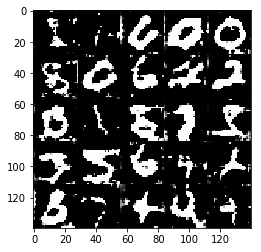

Epoch 2/2... Discriminator Loss: 0.7918... Generator Loss: 0.8723
Epoch 2/2... Discriminator Loss: 0.6911... Generator Loss: 1.1079
Epoch 2/2... Discriminator Loss: 0.4859... Generator Loss: 1.5470
Epoch 2/2... Discriminator Loss: 0.4125... Generator Loss: 1.6275
Epoch 2/2... Discriminator Loss: 0.4155... Generator Loss: 1.7672
Epoch 2/2... Discriminator Loss: 0.6768... Generator Loss: 2.2784
Epoch 2/2... Discriminator Loss: 0.5790... Generator Loss: 1.0939
Epoch 2/2... Discriminator Loss: 1.4469... Generator Loss: 0.3770
Epoch 2/2... Discriminator Loss: 2.6593... Generator Loss: 0.0961
Epoch 2/2... Discriminator Loss: 1.4972... Generator Loss: 0.3487


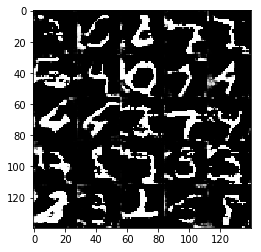

Epoch 2/2... Discriminator Loss: 1.1754... Generator Loss: 0.4875
Epoch 2/2... Discriminator Loss: 1.1539... Generator Loss: 0.4740
Epoch 2/2... Discriminator Loss: 1.2064... Generator Loss: 0.4771
Epoch 2/2... Discriminator Loss: 0.6789... Generator Loss: 1.1563
Epoch 2/2... Discriminator Loss: 2.6647... Generator Loss: 0.1184
Epoch 2/2... Discriminator Loss: 2.6648... Generator Loss: 0.1241
Epoch 2/2... Discriminator Loss: 0.4532... Generator Loss: 1.5564


In [84]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.8665... Generator Loss: 1.2032
Epoch 1/1... Discriminator Loss: 1.8930... Generator Loss: 2.3547
Epoch 1/1... Discriminator Loss: 3.8253... Generator Loss: 0.1006
Epoch 1/1... Discriminator Loss: 3.4660... Generator Loss: 0.5725
Epoch 1/1... Discriminator Loss: 0.9123... Generator Loss: 0.7733
Epoch 1/1... Discriminator Loss: 1.0122... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.5618
Epoch 1/1... Discriminator Loss: 0.7786... Generator Loss: 0.9602
Epoch 1/1... Discriminator Loss: 0.0353... Generator Loss: 4.6934
Epoch 1/1... Discriminator Loss: 0.9249... Generator Loss: 1.7631


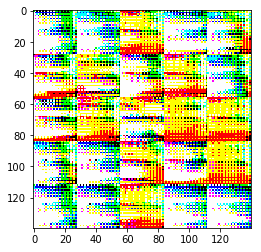

Epoch 1/1... Discriminator Loss: 1.6509... Generator Loss: 0.5347
Epoch 1/1... Discriminator Loss: 0.2441... Generator Loss: 1.6647
Epoch 1/1... Discriminator Loss: 0.7645... Generator Loss: 1.0342
Epoch 1/1... Discriminator Loss: 0.3075... Generator Loss: 1.8511
Epoch 1/1... Discriminator Loss: 0.7269... Generator Loss: 1.1419
Epoch 1/1... Discriminator Loss: 2.1343... Generator Loss: 0.3900
Epoch 1/1... Discriminator Loss: 0.6476... Generator Loss: 3.1988
Epoch 1/1... Discriminator Loss: 0.5698... Generator Loss: 1.7030
Epoch 1/1... Discriminator Loss: 0.2140... Generator Loss: 2.4923
Epoch 1/1... Discriminator Loss: 0.1978... Generator Loss: 1.8524


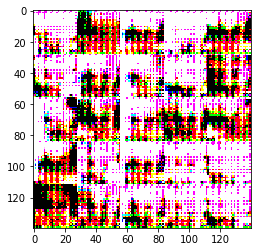

Epoch 1/1... Discriminator Loss: 0.0427... Generator Loss: 3.4942
Epoch 1/1... Discriminator Loss: 0.2683... Generator Loss: 2.2023
Epoch 1/1... Discriminator Loss: 1.5182... Generator Loss: 0.3981
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 2.4930
Epoch 1/1... Discriminator Loss: 0.0785... Generator Loss: 3.6040
Epoch 1/1... Discriminator Loss: 3.1071... Generator Loss: 0.0659
Epoch 1/1... Discriminator Loss: 0.9935... Generator Loss: 0.9147
Epoch 1/1... Discriminator Loss: 0.1574... Generator Loss: 3.2242
Epoch 1/1... Discriminator Loss: 0.3962... Generator Loss: 1.6015
Epoch 1/1... Discriminator Loss: 0.9229... Generator Loss: 7.0823


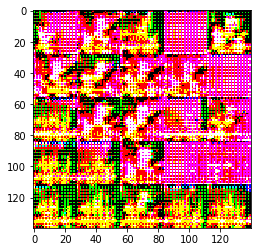

Epoch 1/1... Discriminator Loss: 0.2575... Generator Loss: 2.5382
Epoch 1/1... Discriminator Loss: 2.0639... Generator Loss: 0.2029
Epoch 1/1... Discriminator Loss: 0.3095... Generator Loss: 2.3237
Epoch 1/1... Discriminator Loss: 0.0340... Generator Loss: 6.3489
Epoch 1/1... Discriminator Loss: 0.4989... Generator Loss: 1.0744
Epoch 1/1... Discriminator Loss: 0.7486... Generator Loss: 0.8780
Epoch 1/1... Discriminator Loss: 0.1014... Generator Loss: 2.5171
Epoch 1/1... Discriminator Loss: 0.0345... Generator Loss: 4.7240
Epoch 1/1... Discriminator Loss: 0.1764... Generator Loss: 4.5504
Epoch 1/1... Discriminator Loss: 0.2780... Generator Loss: 3.4845


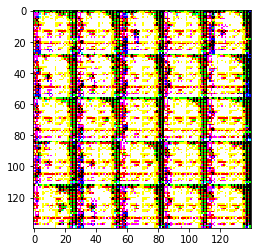

Epoch 1/1... Discriminator Loss: 1.5128... Generator Loss: 0.4966
Epoch 1/1... Discriminator Loss: 0.8028... Generator Loss: 2.7535
Epoch 1/1... Discriminator Loss: 3.1315... Generator Loss: 7.3000
Epoch 1/1... Discriminator Loss: 0.3932... Generator Loss: 3.2651
Epoch 1/1... Discriminator Loss: 0.0116... Generator Loss: 5.1796
Epoch 1/1... Discriminator Loss: 0.1387... Generator Loss: 2.2734
Epoch 1/1... Discriminator Loss: 0.0473... Generator Loss: 4.5660
Epoch 1/1... Discriminator Loss: 1.9145... Generator Loss: 0.1858
Epoch 1/1... Discriminator Loss: 0.3374... Generator Loss: 9.5843
Epoch 1/1... Discriminator Loss: 0.0217... Generator Loss: 4.0531


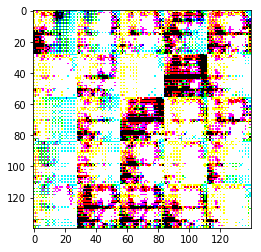

Epoch 1/1... Discriminator Loss: 0.1273... Generator Loss: 2.5053
Epoch 1/1... Discriminator Loss: 0.0304... Generator Loss: 4.3553
Epoch 1/1... Discriminator Loss: 0.0479... Generator Loss: 3.3737
Epoch 1/1... Discriminator Loss: 0.0449... Generator Loss: 4.9023
Epoch 1/1... Discriminator Loss: 0.0154... Generator Loss: 5.6964
Epoch 1/1... Discriminator Loss: 0.0092... Generator Loss: 5.3435
Epoch 1/1... Discriminator Loss: 0.0031... Generator Loss: 6.1196
Epoch 1/1... Discriminator Loss: 0.0015... Generator Loss: 8.1564
Epoch 1/1... Discriminator Loss: 0.0014... Generator Loss: 6.6845
Epoch 1/1... Discriminator Loss: 0.0059... Generator Loss: 5.3314


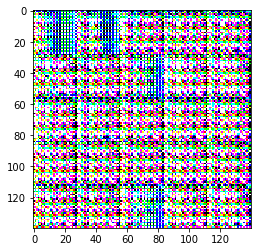

Epoch 1/1... Discriminator Loss: 11.3201... Generator Loss: 21.0844
Epoch 1/1... Discriminator Loss: 0.0680... Generator Loss: 2.7779
Epoch 1/1... Discriminator Loss: 0.0870... Generator Loss: 2.6884
Epoch 1/1... Discriminator Loss: 0.1613... Generator Loss: 2.0996
Epoch 1/1... Discriminator Loss: 0.2452... Generator Loss: 3.4988
Epoch 1/1... Discriminator Loss: 1.0351... Generator Loss: 1.5099
Epoch 1/1... Discriminator Loss: 0.7981... Generator Loss: 1.4979
Epoch 1/1... Discriminator Loss: 0.0301... Generator Loss: 5.5011
Epoch 1/1... Discriminator Loss: 0.1236... Generator Loss: 3.9817
Epoch 1/1... Discriminator Loss: 0.3738... Generator Loss: 1.5141


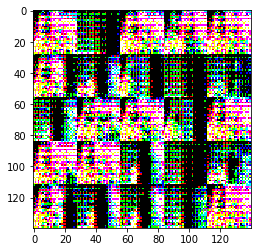

Epoch 1/1... Discriminator Loss: 0.0890... Generator Loss: 4.0869
Epoch 1/1... Discriminator Loss: 0.0062... Generator Loss: 7.0524
Epoch 1/1... Discriminator Loss: 0.0240... Generator Loss: 4.1723
Epoch 1/1... Discriminator Loss: 0.0539... Generator Loss: 3.1366
Epoch 1/1... Discriminator Loss: 0.0274... Generator Loss: 4.1509
Epoch 1/1... Discriminator Loss: 0.0127... Generator Loss: 5.6107
Epoch 1/1... Discriminator Loss: 0.0244... Generator Loss: 4.5548
Epoch 1/1... Discriminator Loss: 0.0074... Generator Loss: 5.6678
Epoch 1/1... Discriminator Loss: 0.0113... Generator Loss: 4.5974
Epoch 1/1... Discriminator Loss: 0.0014... Generator Loss: 9.3234


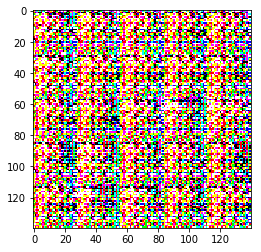

Epoch 1/1... Discriminator Loss: 0.0065... Generator Loss: 5.4557
Epoch 1/1... Discriminator Loss: 0.0022... Generator Loss: 6.5799
Epoch 1/1... Discriminator Loss: 0.0043... Generator Loss: 5.7705
Epoch 1/1... Discriminator Loss: 0.0019... Generator Loss: 6.5432
Epoch 1/1... Discriminator Loss: 0.0015... Generator Loss: 6.7347
Epoch 1/1... Discriminator Loss: 0.0009... Generator Loss: 9.5153
Epoch 1/1... Discriminator Loss: 0.0193... Generator Loss: 7.0947
Epoch 1/1... Discriminator Loss: 0.0421... Generator Loss: 3.5146
Epoch 1/1... Discriminator Loss: 1.5234... Generator Loss: 3.0771
Epoch 1/1... Discriminator Loss: 0.2350... Generator Loss: 2.0015


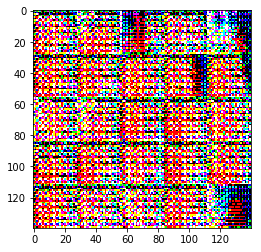

Epoch 1/1... Discriminator Loss: 0.0835... Generator Loss: 2.9059
Epoch 1/1... Discriminator Loss: 0.0893... Generator Loss: 2.8344
Epoch 1/1... Discriminator Loss: 0.9202... Generator Loss: 0.5612
Epoch 1/1... Discriminator Loss: 0.2046... Generator Loss: 1.9872
Epoch 1/1... Discriminator Loss: 0.0200... Generator Loss: 6.3324
Epoch 1/1... Discriminator Loss: 0.0320... Generator Loss: 3.8073
Epoch 1/1... Discriminator Loss: 0.0275... Generator Loss: 4.1847
Epoch 1/1... Discriminator Loss: 1.1866... Generator Loss: 0.4412
Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.4932
Epoch 1/1... Discriminator Loss: 0.9537... Generator Loss: 0.6935


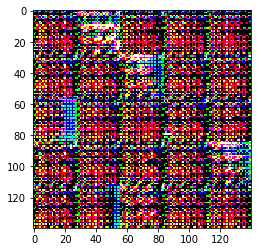

Epoch 1/1... Discriminator Loss: 0.3213... Generator Loss: 1.6082
Epoch 1/1... Discriminator Loss: 1.7360... Generator Loss: 0.5870
Epoch 1/1... Discriminator Loss: 0.3995... Generator Loss: 2.2729
Epoch 1/1... Discriminator Loss: 0.1172... Generator Loss: 2.6934
Epoch 1/1... Discriminator Loss: 0.0196... Generator Loss: 4.6772
Epoch 1/1... Discriminator Loss: 0.0325... Generator Loss: 4.2508
Epoch 1/1... Discriminator Loss: 0.0354... Generator Loss: 3.6739
Epoch 1/1... Discriminator Loss: 0.0525... Generator Loss: 3.3241
Epoch 1/1... Discriminator Loss: 0.0053... Generator Loss: 6.1742
Epoch 1/1... Discriminator Loss: 0.0370... Generator Loss: 3.4194


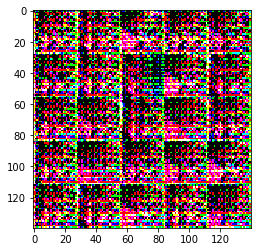

Epoch 1/1... Discriminator Loss: 0.0023... Generator Loss: 8.5509
Epoch 1/1... Discriminator Loss: 0.0069... Generator Loss: 5.8110
Epoch 1/1... Discriminator Loss: 0.0852... Generator Loss: 2.7238
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 5.9679
Epoch 1/1... Discriminator Loss: 0.4143... Generator Loss: 1.6745
Epoch 1/1... Discriminator Loss: 0.1098... Generator Loss: 3.5377
Epoch 1/1... Discriminator Loss: 1.1839... Generator Loss: 3.9471
Epoch 1/1... Discriminator Loss: 0.3535... Generator Loss: 1.9391
Epoch 1/1... Discriminator Loss: 0.1393... Generator Loss: 2.3684
Epoch 1/1... Discriminator Loss: 0.0023... Generator Loss: 7.4365


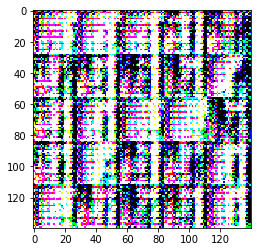

Epoch 1/1... Discriminator Loss: 0.1568... Generator Loss: 2.2117
Epoch 1/1... Discriminator Loss: 0.3664... Generator Loss: 1.5912
Epoch 1/1... Discriminator Loss: 0.1458... Generator Loss: 2.1515
Epoch 1/1... Discriminator Loss: 0.1657... Generator Loss: 3.4436
Epoch 1/1... Discriminator Loss: 0.1377... Generator Loss: 2.3818
Epoch 1/1... Discriminator Loss: 0.1067... Generator Loss: 2.9403
Epoch 1/1... Discriminator Loss: 0.2318... Generator Loss: 1.7443
Epoch 1/1... Discriminator Loss: 0.3077... Generator Loss: 1.8301
Epoch 1/1... Discriminator Loss: 0.4601... Generator Loss: 9.6255
Epoch 1/1... Discriminator Loss: 0.5325... Generator Loss: 2.9954


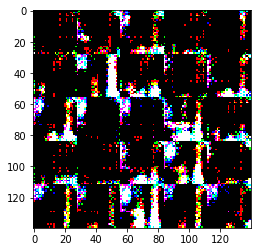

Epoch 1/1... Discriminator Loss: 0.2416... Generator Loss: 2.5441
Epoch 1/1... Discriminator Loss: 0.4854... Generator Loss: 1.8004
Epoch 1/1... Discriminator Loss: 5.1538... Generator Loss: 8.8158
Epoch 1/1... Discriminator Loss: 0.8915... Generator Loss: 0.8274
Epoch 1/1... Discriminator Loss: 0.9181... Generator Loss: 0.7295
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.3283
Epoch 1/1... Discriminator Loss: 0.0945... Generator Loss: 3.4895
Epoch 1/1... Discriminator Loss: 1.4641... Generator Loss: 0.3442
Epoch 1/1... Discriminator Loss: 0.7777... Generator Loss: 1.2127
Epoch 1/1... Discriminator Loss: 0.6765... Generator Loss: 1.2315


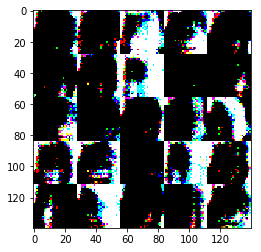

Epoch 1/1... Discriminator Loss: 1.0214... Generator Loss: 1.5295
Epoch 1/1... Discriminator Loss: 0.4609... Generator Loss: 1.2644
Epoch 1/1... Discriminator Loss: 0.9555... Generator Loss: 1.0604
Epoch 1/1... Discriminator Loss: 0.8693... Generator Loss: 1.3187
Epoch 1/1... Discriminator Loss: 0.4345... Generator Loss: 1.3621
Epoch 1/1... Discriminator Loss: 0.9644... Generator Loss: 0.9200
Epoch 1/1... Discriminator Loss: 0.9121... Generator Loss: 1.0316
Epoch 1/1... Discriminator Loss: 1.0987... Generator Loss: 0.5657
Epoch 1/1... Discriminator Loss: 0.4623... Generator Loss: 1.7549
Epoch 1/1... Discriminator Loss: 1.9331... Generator Loss: 0.6572


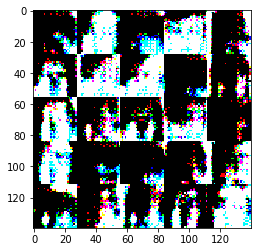

Epoch 1/1... Discriminator Loss: 1.5040... Generator Loss: 3.5363
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.3556
Epoch 1/1... Discriminator Loss: 0.7302... Generator Loss: 0.8422
Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.4297
Epoch 1/1... Discriminator Loss: 1.0548... Generator Loss: 1.2071
Epoch 1/1... Discriminator Loss: 0.8388... Generator Loss: 1.1308
Epoch 1/1... Discriminator Loss: 0.1961... Generator Loss: 2.6677
Epoch 1/1... Discriminator Loss: 0.8289... Generator Loss: 1.0603
Epoch 1/1... Discriminator Loss: 0.6756... Generator Loss: 1.1009
Epoch 1/1... Discriminator Loss: 1.7930... Generator Loss: 0.6268


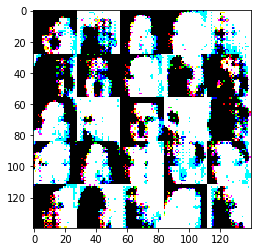

Epoch 1/1... Discriminator Loss: 0.7404... Generator Loss: 1.3848
Epoch 1/1... Discriminator Loss: 1.2380... Generator Loss: 0.5181
Epoch 1/1... Discriminator Loss: 1.7758... Generator Loss: 0.3008
Epoch 1/1... Discriminator Loss: 0.5325... Generator Loss: 1.4071
Epoch 1/1... Discriminator Loss: 0.5651... Generator Loss: 1.6946
Epoch 1/1... Discriminator Loss: 1.5087... Generator Loss: 0.3927
Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 0.8258
Epoch 1/1... Discriminator Loss: 2.3279... Generator Loss: 0.2286
Epoch 1/1... Discriminator Loss: 1.1261... Generator Loss: 0.5112
Epoch 1/1... Discriminator Loss: 0.8813... Generator Loss: 2.4861


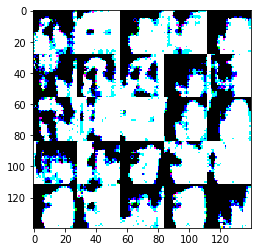

Epoch 1/1... Discriminator Loss: 0.6666... Generator Loss: 1.1642
Epoch 1/1... Discriminator Loss: 1.2059... Generator Loss: 0.5999
Epoch 1/1... Discriminator Loss: 0.9531... Generator Loss: 0.7825
Epoch 1/1... Discriminator Loss: 0.5022... Generator Loss: 1.4070
Epoch 1/1... Discriminator Loss: 0.4255... Generator Loss: 1.7609
Epoch 1/1... Discriminator Loss: 1.2662... Generator Loss: 1.2128
Epoch 1/1... Discriminator Loss: 1.1007... Generator Loss: 0.8826
Epoch 1/1... Discriminator Loss: 0.9137... Generator Loss: 0.9590
Epoch 1/1... Discriminator Loss: 0.9401... Generator Loss: 1.6004
Epoch 1/1... Discriminator Loss: 0.8021... Generator Loss: 2.1631


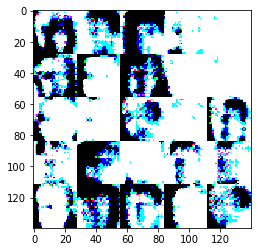

Epoch 1/1... Discriminator Loss: 0.5709... Generator Loss: 1.3328
Epoch 1/1... Discriminator Loss: 1.4449... Generator Loss: 0.3325
Epoch 1/1... Discriminator Loss: 2.1950... Generator Loss: 2.8186
Epoch 1/1... Discriminator Loss: 1.1275... Generator Loss: 0.5062
Epoch 1/1... Discriminator Loss: 1.1974... Generator Loss: 0.4520
Epoch 1/1... Discriminator Loss: 0.5956... Generator Loss: 2.9972
Epoch 1/1... Discriminator Loss: 1.9812... Generator Loss: 0.1776
Epoch 1/1... Discriminator Loss: 0.8431... Generator Loss: 0.7739
Epoch 1/1... Discriminator Loss: 0.9829... Generator Loss: 1.6470
Epoch 1/1... Discriminator Loss: 0.9422... Generator Loss: 1.3833


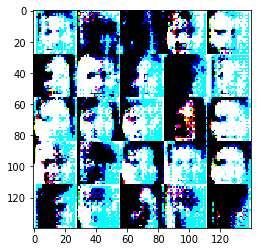

Epoch 1/1... Discriminator Loss: 1.0556... Generator Loss: 1.0023
Epoch 1/1... Discriminator Loss: 0.8002... Generator Loss: 0.7078
Epoch 1/1... Discriminator Loss: 0.7772... Generator Loss: 0.8004
Epoch 1/1... Discriminator Loss: 0.5963... Generator Loss: 1.1199
Epoch 1/1... Discriminator Loss: 2.6966... Generator Loss: 3.3650
Epoch 1/1... Discriminator Loss: 1.2244... Generator Loss: 0.4703
Epoch 1/1... Discriminator Loss: 1.0322... Generator Loss: 0.7783
Epoch 1/1... Discriminator Loss: 0.7369... Generator Loss: 2.2244
Epoch 1/1... Discriminator Loss: 0.7284... Generator Loss: 2.1663
Epoch 1/1... Discriminator Loss: 1.8372... Generator Loss: 0.6978


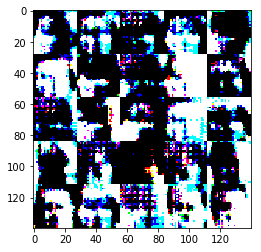

Epoch 1/1... Discriminator Loss: 0.3216... Generator Loss: 1.7357
Epoch 1/1... Discriminator Loss: 1.7208... Generator Loss: 0.3704
Epoch 1/1... Discriminator Loss: 2.2837... Generator Loss: 2.0163
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.8864
Epoch 1/1... Discriminator Loss: 1.2099... Generator Loss: 1.0728
Epoch 1/1... Discriminator Loss: 1.0108... Generator Loss: 2.4933
Epoch 1/1... Discriminator Loss: 0.6134... Generator Loss: 1.0205
Epoch 1/1... Discriminator Loss: 0.2844... Generator Loss: 1.9529
Epoch 1/1... Discriminator Loss: 1.9925... Generator Loss: 0.2457
Epoch 1/1... Discriminator Loss: 1.4769... Generator Loss: 2.5176


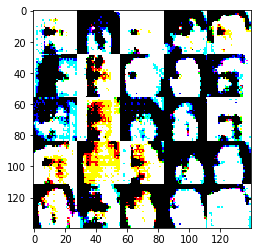

Epoch 1/1... Discriminator Loss: 1.3034... Generator Loss: 0.3664
Epoch 1/1... Discriminator Loss: 0.3666... Generator Loss: 1.5226
Epoch 1/1... Discriminator Loss: 1.5014... Generator Loss: 0.5624
Epoch 1/1... Discriminator Loss: 0.9153... Generator Loss: 1.4500
Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 0.5551
Epoch 1/1... Discriminator Loss: 0.2203... Generator Loss: 2.8281
Epoch 1/1... Discriminator Loss: 0.7787... Generator Loss: 1.1931
Epoch 1/1... Discriminator Loss: 0.4965... Generator Loss: 1.6927
Epoch 1/1... Discriminator Loss: 0.9405... Generator Loss: 1.5280
Epoch 1/1... Discriminator Loss: 0.0241... Generator Loss: 4.4977


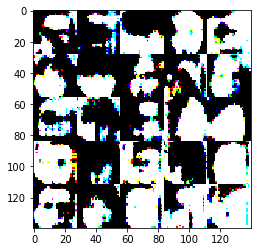

Epoch 1/1... Discriminator Loss: 1.7197... Generator Loss: 1.6090
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.7885
Epoch 1/1... Discriminator Loss: 0.9302... Generator Loss: 0.9750
Epoch 1/1... Discriminator Loss: 0.9245... Generator Loss: 1.1386
Epoch 1/1... Discriminator Loss: 0.9996... Generator Loss: 0.6472
Epoch 1/1... Discriminator Loss: 1.4665... Generator Loss: 0.5361
Epoch 1/1... Discriminator Loss: 0.8472... Generator Loss: 1.7624
Epoch 1/1... Discriminator Loss: 0.5686... Generator Loss: 1.4051
Epoch 1/1... Discriminator Loss: 0.5848... Generator Loss: 1.6982
Epoch 1/1... Discriminator Loss: 0.6202... Generator Loss: 2.8611


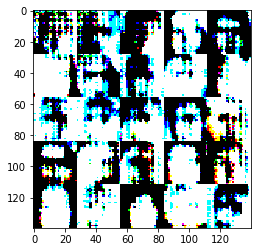

Epoch 1/1... Discriminator Loss: 0.6396... Generator Loss: 0.9333
Epoch 1/1... Discriminator Loss: 0.9010... Generator Loss: 0.6871
Epoch 1/1... Discriminator Loss: 0.0146... Generator Loss: 4.8187
Epoch 1/1... Discriminator Loss: 0.0022... Generator Loss: 9.7058
Epoch 1/1... Discriminator Loss: 0.0057... Generator Loss: 13.6478
Epoch 1/1... Discriminator Loss: 0.0107... Generator Loss: 4.9184
Epoch 1/1... Discriminator Loss: 7.7371... Generator Loss: 14.6791
Epoch 1/1... Discriminator Loss: 0.4924... Generator Loss: 2.9079
Epoch 1/1... Discriminator Loss: 0.0488... Generator Loss: 4.0535
Epoch 1/1... Discriminator Loss: 7.1195... Generator Loss: 9.3027


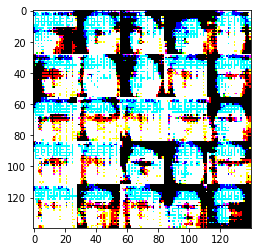

Epoch 1/1... Discriminator Loss: 0.3134... Generator Loss: 1.7768
Epoch 1/1... Discriminator Loss: 1.0858... Generator Loss: 0.6399
Epoch 1/1... Discriminator Loss: 0.7736... Generator Loss: 3.1114
Epoch 1/1... Discriminator Loss: 0.1654... Generator Loss: 2.2810
Epoch 1/1... Discriminator Loss: 0.5071... Generator Loss: 1.3196
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.6724
Epoch 1/1... Discriminator Loss: 1.6050... Generator Loss: 0.6046
Epoch 1/1... Discriminator Loss: 1.0679... Generator Loss: 0.9438
Epoch 1/1... Discriminator Loss: 1.0700... Generator Loss: 1.0599
Epoch 1/1... Discriminator Loss: 0.9854... Generator Loss: 1.1008


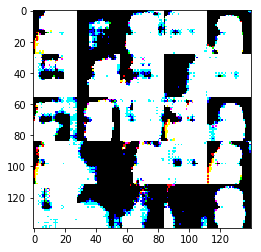

Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.4436
Epoch 1/1... Discriminator Loss: 1.0401... Generator Loss: 0.7457
Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.5080
Epoch 1/1... Discriminator Loss: 1.0602... Generator Loss: 0.6839
Epoch 1/1... Discriminator Loss: 1.6407... Generator Loss: 0.8226
Epoch 1/1... Discriminator Loss: 1.6457... Generator Loss: 2.0569
Epoch 1/1... Discriminator Loss: 1.3705... Generator Loss: 0.8026
Epoch 1/1... Discriminator Loss: 1.1425... Generator Loss: 0.7886
Epoch 1/1... Discriminator Loss: 2.2409... Generator Loss: 0.1312
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.5418


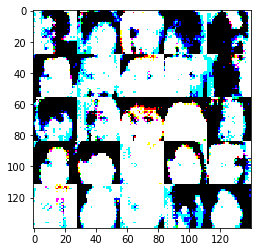

Epoch 1/1... Discriminator Loss: 1.3398... Generator Loss: 0.4418
Epoch 1/1... Discriminator Loss: 0.2710... Generator Loss: 2.6554
Epoch 1/1... Discriminator Loss: 0.0864... Generator Loss: 2.8041
Epoch 1/1... Discriminator Loss: 0.0336... Generator Loss: 3.9364
Epoch 1/1... Discriminator Loss: 0.0509... Generator Loss: 3.1823
Epoch 1/1... Discriminator Loss: 5.9342... Generator Loss: 10.1435
Epoch 1/1... Discriminator Loss: 1.2829... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 0.5705... Generator Loss: 1.6244
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 2.2883
Epoch 1/1... Discriminator Loss: 0.5765... Generator Loss: 1.0027


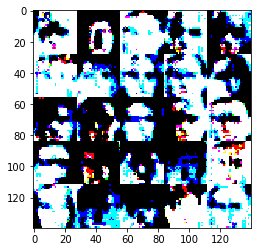

Epoch 1/1... Discriminator Loss: 0.6579... Generator Loss: 3.1283
Epoch 1/1... Discriminator Loss: 0.8986... Generator Loss: 1.2778
Epoch 1/1... Discriminator Loss: 0.4704... Generator Loss: 1.3811
Epoch 1/1... Discriminator Loss: 2.2259... Generator Loss: 0.1496
Epoch 1/1... Discriminator Loss: 0.2381... Generator Loss: 1.7960
Epoch 1/1... Discriminator Loss: 1.1003... Generator Loss: 0.5254
Epoch 1/1... Discriminator Loss: 2.7319... Generator Loss: 4.0772
Epoch 1/1... Discriminator Loss: 1.2496... Generator Loss: 2.3672
Epoch 1/1... Discriminator Loss: 1.1668... Generator Loss: 0.9815
Epoch 1/1... Discriminator Loss: 0.4184... Generator Loss: 3.8522


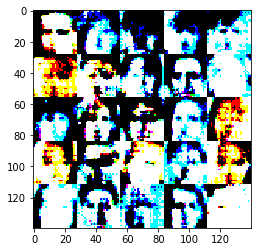

Epoch 1/1... Discriminator Loss: 0.3065... Generator Loss: 1.7936
Epoch 1/1... Discriminator Loss: 0.3330... Generator Loss: 1.5508
Epoch 1/1... Discriminator Loss: 0.6524... Generator Loss: 3.7801
Epoch 1/1... Discriminator Loss: 0.0437... Generator Loss: 3.2721
Epoch 1/1... Discriminator Loss: 0.0531... Generator Loss: 3.4944
Epoch 1/1... Discriminator Loss: 0.0537... Generator Loss: 3.4175
Epoch 1/1... Discriminator Loss: 0.0192... Generator Loss: 5.5682
Epoch 1/1... Discriminator Loss: 0.0036... Generator Loss: 6.6356
Epoch 1/1... Discriminator Loss: 0.2033... Generator Loss: 1.9946
Epoch 1/1... Discriminator Loss: 0.0153... Generator Loss: 4.7742


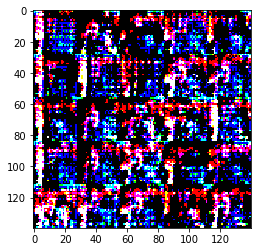

Epoch 1/1... Discriminator Loss: 0.0116... Generator Loss: 4.7909
Epoch 1/1... Discriminator Loss: 0.0073... Generator Loss: 5.1542
Epoch 1/1... Discriminator Loss: 0.0057... Generator Loss: 5.5440
Epoch 1/1... Discriminator Loss: 0.0190... Generator Loss: 4.2049
Epoch 1/1... Discriminator Loss: 0.0479... Generator Loss: 3.2443
Epoch 1/1... Discriminator Loss: 0.0039... Generator Loss: 6.1137
Epoch 1/1... Discriminator Loss: 0.0033... Generator Loss: 6.2261
Epoch 1/1... Discriminator Loss: 0.0155... Generator Loss: 4.4983
Epoch 1/1... Discriminator Loss: 0.0017... Generator Loss: 10.8004
Epoch 1/1... Discriminator Loss: 0.0024... Generator Loss: 6.5089


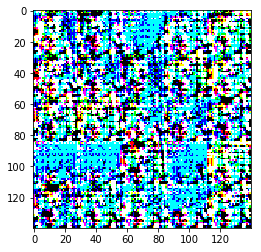

Epoch 1/1... Discriminator Loss: 0.0014... Generator Loss: 7.4128
Epoch 1/1... Discriminator Loss: 0.0026... Generator Loss: 6.5279
Epoch 1/1... Discriminator Loss: 0.0016... Generator Loss: 7.0124
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 15.6083
Epoch 1/1... Discriminator Loss: 0.0016... Generator Loss: 6.9174
Epoch 1/1... Discriminator Loss: 0.0010... Generator Loss: 7.3361
Epoch 1/1... Discriminator Loss: 0.0025... Generator Loss: 6.1284
Epoch 1/1... Discriminator Loss: 0.0025... Generator Loss: 6.2893
Epoch 1/1... Discriminator Loss: 0.0006... Generator Loss: 10.5437
Epoch 1/1... Discriminator Loss: 0.0009... Generator Loss: 7.8221


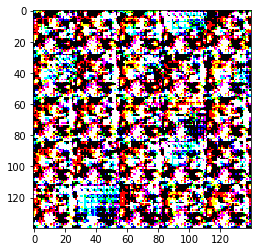

Epoch 1/1... Discriminator Loss: 0.0005... Generator Loss: 11.2204
Epoch 1/1... Discriminator Loss: 0.0006... Generator Loss: 11.2511
Epoch 1/1... Discriminator Loss: 0.0004... Generator Loss: 13.6671
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 12.5039
Epoch 1/1... Discriminator Loss: 0.0011... Generator Loss: 7.3989
Epoch 1/1... Discriminator Loss: 0.0010... Generator Loss: 7.1771


In [85]:
batch_size = 64
z_dim = 100
learning_rate = 0.01
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.